This is part 1 of my analysis of Benjamin Pavard's goal against Argentina in the quarter finals of the 2018 FIFA World Cup. 

In [1]:
import polars as pl 
from statsbombpy import sb 

import mplsoccer as mpl
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

import sys
sys.path.append("..") 
sys.dont_write_bytecode = True

import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils.statics import figsize, PITCH_X, PITCH_Y, xg_scale_factor, gmm_n_components
from utils.utils import (invert_orientation, invert_one_orientation, add_legend, plot_player_positions, plot_pitch_with_shots, plot_gmm_components, evaluate_and_plot_gmm_pdf)
from utils.EventsHandler import EventsHandler
from utils.ShotsHandler import ShotsHandler
from utils.GMMHandler import GMMHandler

# Prepare the data
Call the matches method from the ``sb`` module. The method calls the Statsbomb API and returns a Pandas dataframe of all matches for the provided ``competition_id`` and ``season_id``. I have decided to do perform this analysis using the ``polars`` library, since its syntax is more similar to PySpark.

You can read more about polars here: https://pola.rs/

In [3]:
wc2018_matches_df = sb.matches(competition_id=43, season_id=3).sort_values('match_date', ascending=False)
wc2018_matches = pl.from_pandas(wc2018_matches_df)

In [4]:
wc2018_matches.select(pl.col("competition_stage").unique())

competition_stage
str
"""Round of 16"""
"""Quarter-finals"""
"""Semi-finals"""
"""3rd Place Final"""
"""Group Stage"""
"""Final"""


Now let us find the Round of 16 match between France and Argentina

In [5]:
ro16_match = wc2018_matches.filter((pl.col("competition_stage") == "Round of 16") & ((pl.col("home_team") == 'France') | (pl.col("away_team") == 'France')))

Now for this particular match, we have to call the events method to get event data for this match.

In [6]:
match_id = 7580
events_df = sb.events(match_id = match_id)
events = pl.from_pandas(events_df)


# Match statistics
I am specifically interested in analysing the Benjamin Pavard's goal that made the score 2-2, but let us first explore some interesting statistics for 
this game.

In [7]:
team_name1 = "France"
team_name2 = "Argentina"

events_handler = EventsHandler(events, team_name1, team_name2)

## Events
We first filter the Polars dataframe to obtain the events with a location for France and Argentina respectively. 

In [8]:
france_events = events_handler.compute_team_events(team_name1)    
arg_events = events_handler.compute_team_events(team_name2)

# Goals and expected goals (xG)
The game between France and Argentina ended 4-3. Despite Argentina outshooting France with 10 shots to 9, both with 4 on target, France managed to convert their chances better. We plot all shots as well as all goals. 

In [9]:
france_shots = france_events.filter(pl.col("type") == "Shot")
france_shots_handler = ShotsHandler(france_shots)

france_shots_x, france_shots_y = france_shots_handler.compute_shot_x_y_locations()
france_goal_x, france_goal_y = france_shots_handler.compute_goal_x_y_locations()
france_shots_xg = france_shots_handler.compute_xg_from_goal_events()

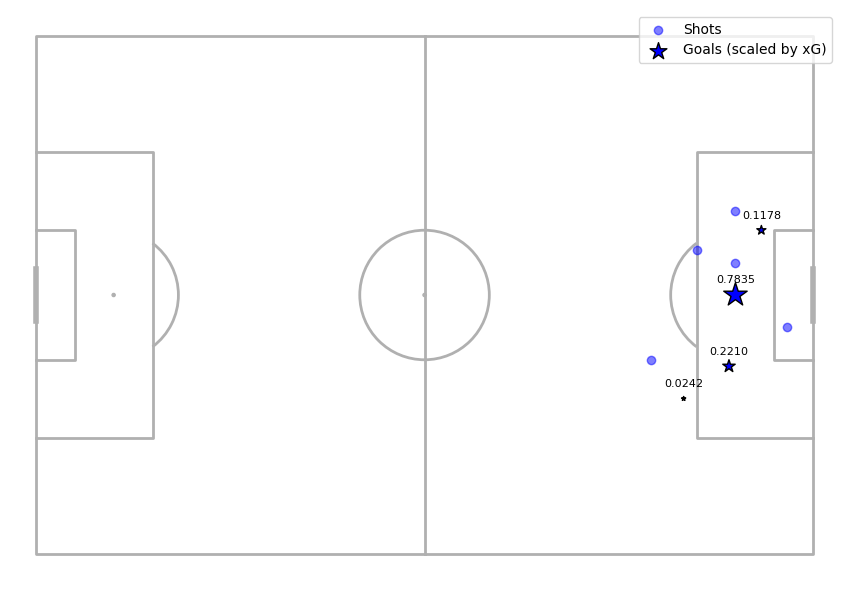

In [10]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)

plot_pitch_with_shots(ax, france_shots_x, france_shots_y, france_goal_x, france_goal_y, france_shots_xg, xg_scale_factor, color='blue')

We observe that the majority of France's shots are taken within the penalty box. This suggests their play style against Argentina put their attackers into favourable positions with favourable shooting positions. 

One of the shots taken outside the box was Pavard's half volley with an xG of just 0.0242 based on StatBomb's computations (This is a goal we will dive deeper into in the next part of the analysis). In contrast, another goal has an enormous xG of 0.7835, meaning a conversion rate of almost 80% from this position. If you haven't figured it out already, this is the penalty taken by Mbappe. When you compare it to the two other goals with more modest xG values of 0.1178 and 0.2210, it clearly highlights the just how decisive and high-quality a penalty kick can be.

Now we plot the same for Argentina.

In [11]:
argentina_shots = arg_events.filter(pl.col("type") == "Shot")
argentina_shots_handler = ShotsHandler(argentina_shots)
argentina_shots_x, argentina_shots_y = invert_orientation(*argentina_shots_handler.compute_shot_x_y_locations(), PITCH_X, PITCH_Y)
argentina_goal_x, argentina_goal_y = invert_orientation(*argentina_shots_handler.compute_goal_x_y_locations(), PITCH_X, PITCH_Y)
argentina_shots_xg = argentina_shots_handler.compute_xg_from_goal_events()

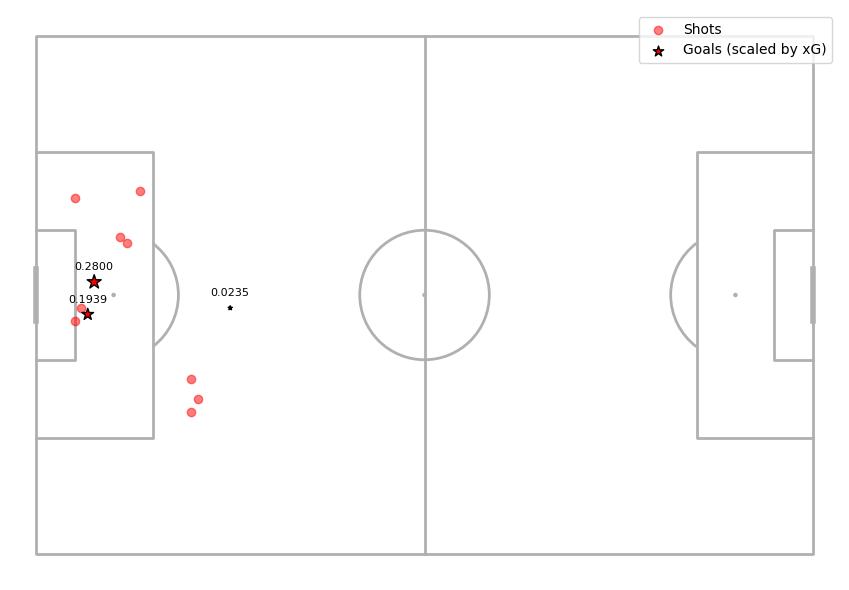

In [12]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)

plot_pitch_with_shots(ax, argentina_shots_x, argentina_shots_y, argentina_goal_x, argentina_goal_y, argentina_shots_xg, xg_scale_factor, color='red')

Interestingly, Argentina shoots more often from outside the box, particularly from the left where Di Maria is placed in the attack. They also has a outside-the-box goal with a similarly low xG value. 

# Heat map for event density

We extract the (x,y) coordinates for all France's and Argentina's actions.

In [13]:
france_x, france_y = events_handler.extract_x_y_location_from_events(team_name1)
argentina_x, argentina_y = events_handler.extract_x_y_location_from_events(team_name2)

# reverse the orientation of Argentina's actions
arg_x, arg_y = invert_orientation(argentina_x, argentina_y, PITCH_X, PITCH_Y)

To get an idea of where their actions are taken on the pitch, we construct a Kernel Density Estimation plot on top of the pitch.

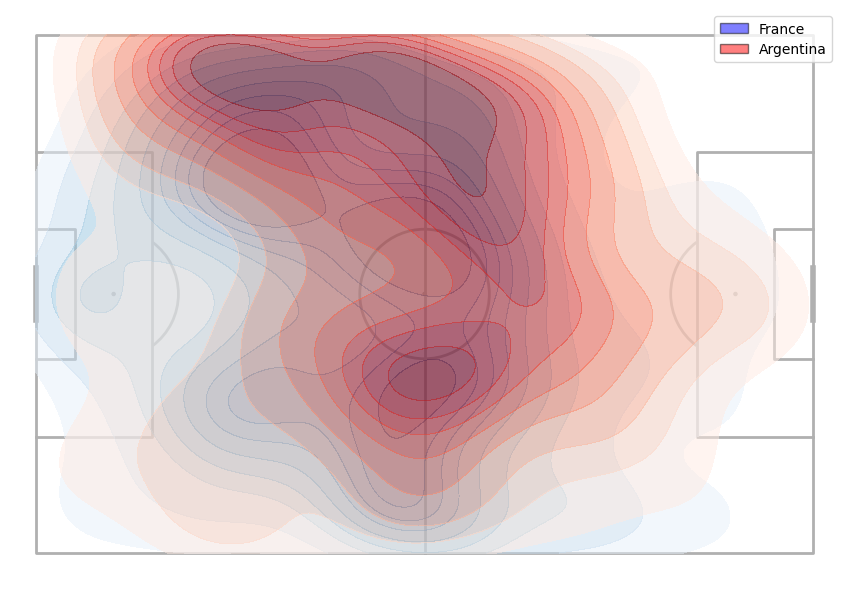

In [14]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)
k1 = pitch.kdeplot(france_x, france_y, cmap='Blues', fill=True, levels=10, alpha=0.5, ax=ax)
k2 = pitch.kdeplot(arg_x, arg_y, cmap='Reds', fill=True, levels=10, alpha=0.5, ax=ax)

add_legend(ax=ax, num_elements=2, colors=["blue", "red"], labels=["France", "Argentina"])


France seems to have dominated the midfield, and with a double pivot of N'Golo Kante and Paul Pogba, with the addition of Blaise Matuidi on the left, this reflects the density peaks in those positions.

Argentina on the other hand seems to have taken most of their actions on the right side. Looking at their starting lineup, this isn't immediately clear, but we can investigate this by looking at the players and the actions they have taken. Inspired by [this post](https://karun.in/blog/interactive-passing-networks.html) by Karun Singh, let us plot the average positions of the players of the starting 11.

In [15]:
france_avg_pos = events_handler.compute_avg_pos_for_starting_xi(team_name1)
argentina_avg_pos = events_handler.compute_avg_pos_for_starting_xi(team_name2)

In [16]:
starting_xi = events_handler.get_starting_xi_from_events_df()

In [17]:
france_avg_pos_with_starting_xi = france_avg_pos.join(starting_xi, on="player_id", how="left")
argentina_avg_pos_with_starting_xi = argentina_avg_pos.join(starting_xi, on="player_id", how="left")

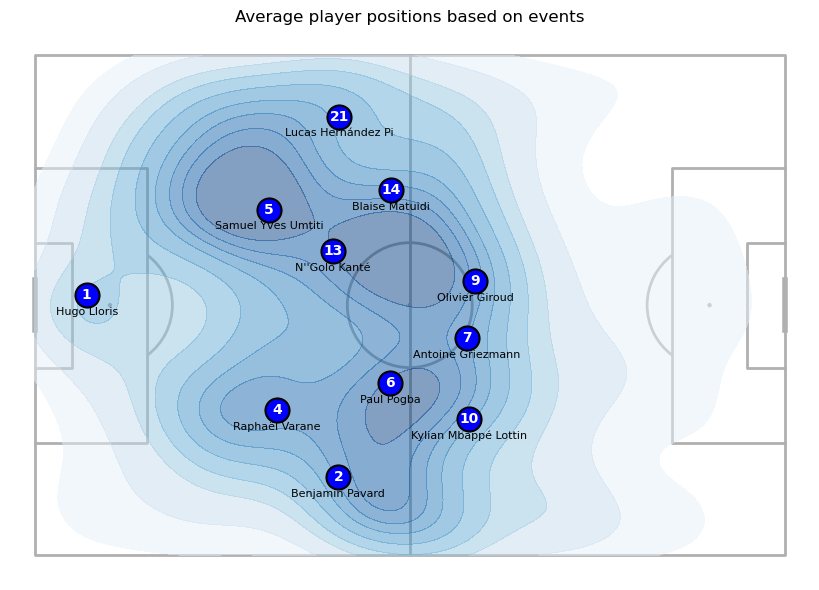

In [18]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)
k1 = pitch.kdeplot(france_x, france_y, cmap='Blues', fill=True, levels=10, alpha=0.5, ax=ax)

x, y = france_avg_pos_with_starting_xi["avg_x"].to_numpy(), france_avg_pos_with_starting_xi["avg_y"].to_numpy()
jerseys = france_avg_pos_with_starting_xi["jersey_number"].to_list()
names = france_avg_pos_with_starting_xi["player_name"].to_list()

plot_player_positions(x=x, y=y, jerseys=jerseys, names=names, pitch=pitch, ax=ax, color='blue', fontsize=12, alpha=0.7, offset=10)


We indeed see that Blaise Matuidi has dropped inwards from the wing and tucks into the left side of the midfield, forming a three-man midfield with Kante and Pogba. Even though their starting lineup is a 4-2-3-1 on paper, the data shows that they are mainly lining up in a 4-3-3. Now let us do the same for Argentina.

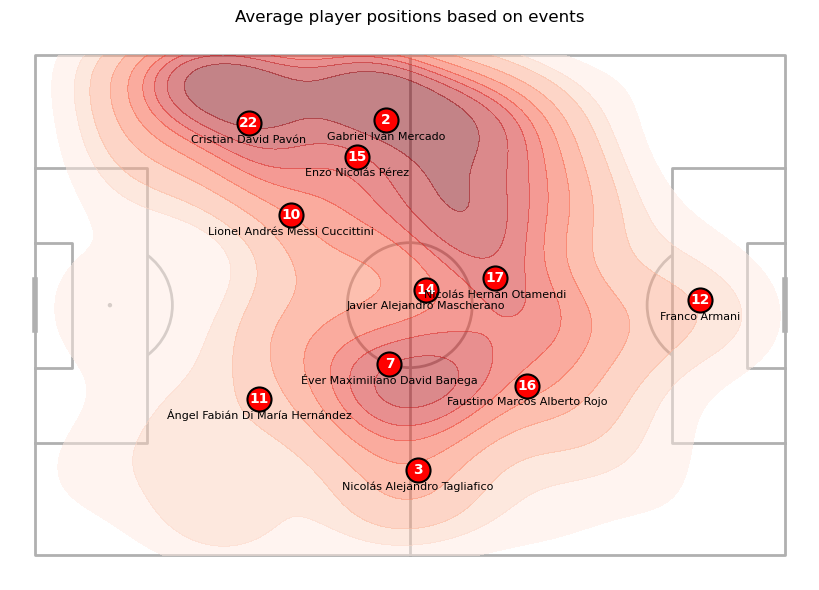

In [19]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)
k2 = pitch.kdeplot(arg_x, arg_y, cmap='Reds', fill=True, levels=10, alpha=0.5, ax=ax)

x, y = argentina_avg_pos_with_starting_xi["avg_x"].to_numpy(), argentina_avg_pos_with_starting_xi["avg_y"].to_numpy()
x_inverted = invert_one_orientation(x, PITCH_X)  # Invert x-coordinates for Argentina
y_inverted = invert_one_orientation(y, PITCH_Y)  # Invert y-coordinates for Argentina
jerseys = argentina_avg_pos_with_starting_xi["jersey_number"].to_list()
names = argentina_avg_pos_with_starting_xi["player_name"].to_list()
plot_player_positions(x=x_inverted, y=y_inverted, jerseys=jerseys, names=names, pitch=pitch, ax=ax, color='red', fontsize=12, alpha=0.7, offset=10)

Wow! The data clearly shows that Argentina has overloaded the right side, pushing up Pavon, Perez and Mercado into the same space. Even though they line up in a 4-3-3, their average positions resemble something like a 2-4-4 formation. Very unusual!

# Analysing possession and tactics using Gaussian Mixture models
Non-linear relationships in football are everywhere because the game is dynamic, and constrained by spatial and tactical rules. To analyse possession patterns and tactics of France and Argentina, we turn our heads to Gaussian mixture models (GMM) due to their ability to capture the underlying structure in complex, multi-dimensional data.

As the name suggests, Gaussian mixture models are constructed by using a mixture of Gaussian distributions, each weighted with a mixture weight $\pi_k$:
$$
p(\bf{x}) = \sum_{k=1}^K \pi_k \, \mathcal{N}(\bf{x} | \bf{\mu}_k, \bf{\Sigma}_k)
$$

We fit a GMM for both France and Argentina using event data leading up to the Round of 16, i.e. all group stage matches

In [20]:
france_gmm_handler = GMMHandler(france_events, invert_coords=False)
argentina_gmm_handler = GMMHandler(arg_events, invert_coords=True)

In [21]:
france_possesion_events = france_gmm_handler.get_possession_events()
argentina_possesion_events = argentina_gmm_handler.get_possession_events()

In [22]:
france_features = france_possesion_events.select(pl.col("x2"), pl.col("y2"))
france_gmm = france_gmm_handler.fit_gmm(france_features)

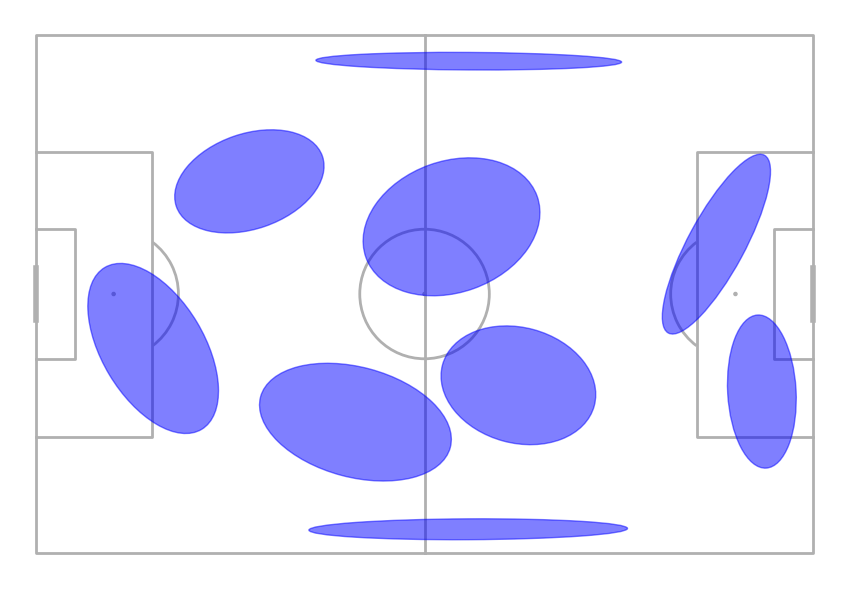

In [23]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
plot_gmm_components(france_gmm, ax, color='blue')

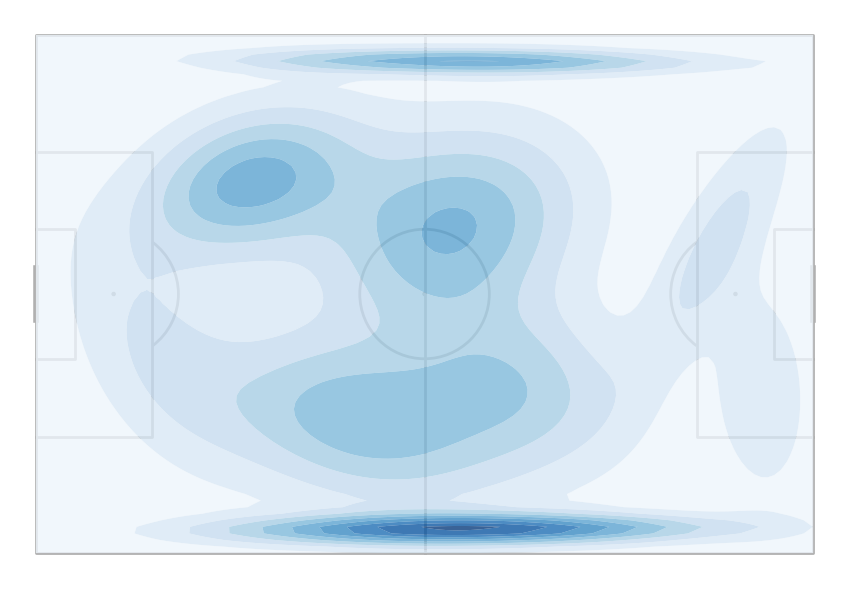

In [24]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
evaluate_and_plot_gmm_pdf(ax, france_gmm, PITCH_X, PITCH_Y, cmap='Blues')

In [25]:
argentina_features = argentina_possesion_events.select(pl.col("x2"), pl.col("y2"))
argentina_gmm = argentina_gmm_handler.fit_gmm(argentina_features)

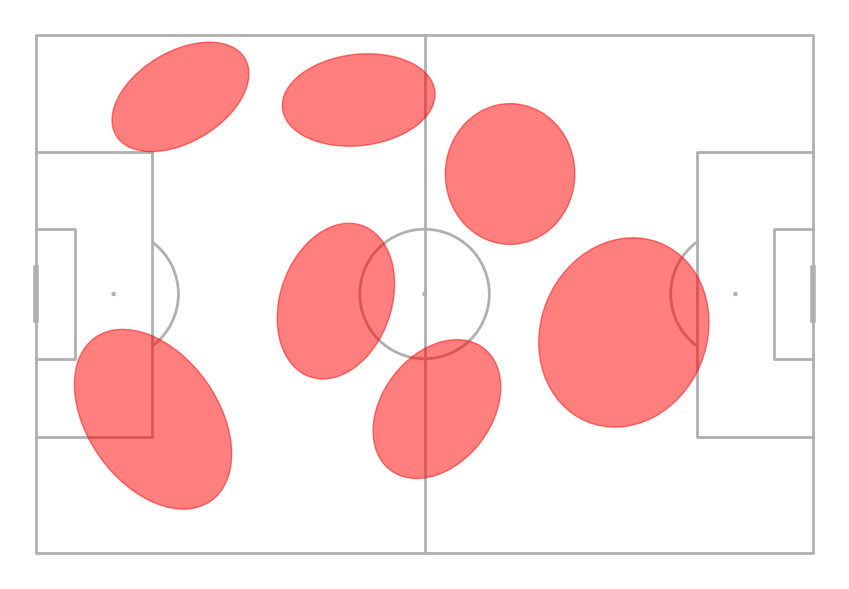

In [26]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
plot_gmm_components(argentina_gmm, ax, color='red')

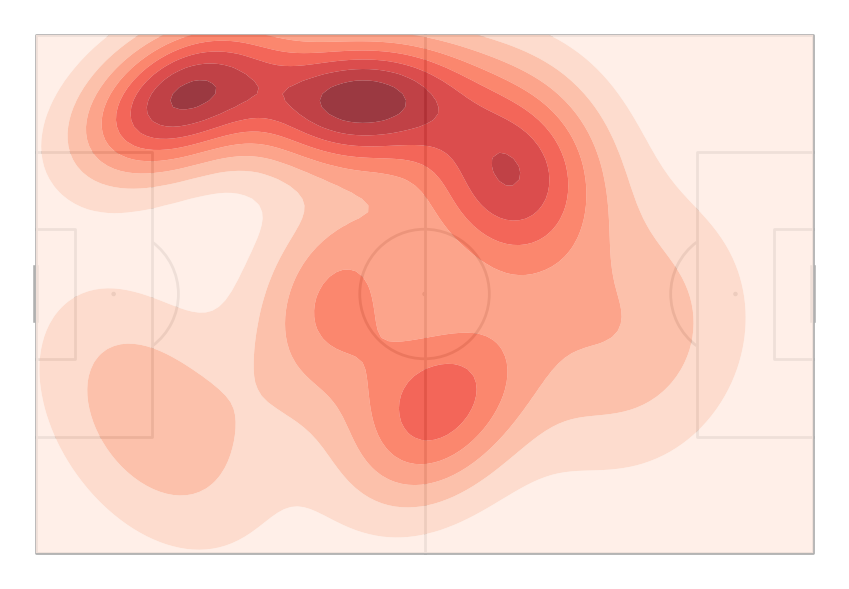

In [27]:
pitch = mpl.Pitch()
fig, ax = pitch.draw(figsize=figsize)
evaluate_and_plot_gmm_pdf(ax, argentina_gmm, PITCH_X, PITCH_Y, cmap='Reds')